Домашнее задание 
===

Данные
----
Данные содержат информацию о продажах автомобилей в месяц. 

Задание
--
* Построить модель предсказаний, используя библиотеку Propeht. 
* Сделать предсказание на год вперед (12 месяцев)
* При постоении модели использовать кросс-валидацию

In [10]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error, r2_score
#dataset
import pandas as pd
import numpy as np

warnings.filterwarnings("ignore") 

df = pd.read_csv('monthly-car-sales.csv')
df


,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587
...,...,...
103,1968-08,16722
104,1968-09,14385
105,1968-10,21342
106,1968-11,17180


<AxesSubplot:>

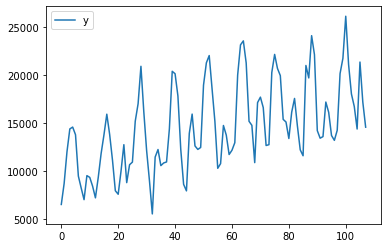

In [11]:
pd.to_datetime(df['Month'])

df.rename(columns = {'Month': 'ds',
                    'Sales': 'y'},
         inplace=True)

metrics_result_table = pd.DataFrame(columns=['Комментарий',
                                             'MAE']) # сюда буду складывать результаты

df[].plot()


In [2]:
# пробовать с верхним блоком
df.set_index(pd.to_datetime(df['Month']),
            inplace=True)

df.rename(columns = {'Month': 'ds',
                    'Sales': 'y'},
         inplace=True)

metrics_result_table = pd.DataFrame(columns=['Комментарий',
                                             'MAE']) # сюда буду складывать результаты


df

,ds,y
Month,,
1960-01-01,1960-01,6550
1960-02-01,1960-02,8728
1960-03-01,1960-03,12026
1960-04-01,1960-04,14395
1960-05-01,1960-05,14587
...,...,...
1968-08-01,1968-08,16722
1968-09-01,1968-09,14385
1968-10-01,1968-10,21342


In [6]:
def modeling (model, picture = False): # создаю сразу функцию, так как однотипных построений будет много 
    m.fit(df)
    future = m.make_future_dataframe(periods=12, freq = "M")
    forecast = m.predict(future)
    cross_valid = cross_validation(m, horizon='365 days')
    metrics = performance_metrics(cross_valid) 
               
    if picture: # рисовать график, если передаем True
        fig = m.plot(forecast)
    
    return metrics.mean()['mae'] 

In [7]:
m = Prophet()
a = modeling(m, picture = True)
metrics_result_table.loc[len(metrics_result_table.index)] = ['by default', a]

11:30:33 - cmdstanpy - INFO - Chain [1] start processing
11:30:36 - cmdstanpy - INFO - Chain [1] done processing
11:30:36 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 
Optimization terminated abnormally. Falling back to Newton.
11:30:36 - cmdstanpy - INFO - Chain [1] start processing
11:30:37 - cmdstanpy - INFO - Chain [1] done processing
11:30:37 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 


RuntimeError: Error during optimization: 

In [ ]:
metrics_result_table

In [ ]:
# Пробуем добавить другую операцию для сезонности
m = Prophet(seasonality_mode='multiplicative')

a = modeling(m, picture = True)
metrics_result_table.loc[len(metrics_result_table.index)] = ['multiplicative', a]


In [ ]:
metrics_result_table.sort_values(by=['MAE'])

Показатели стали хуже - значит нужно вернуться к аддитивной

In [8]:
# добавим еще одну фичу - среднее за каждый месяц
df['mnth']=df.index.month
avg_vals_mnth = df.groupby('mnth')['y'].mean()
df = df.assign(mnth_avg=df['mnth'].map(avg_vals_mnth))
df

AttributeError: 'RangeIndex' object has no attribute 'month'

In [ ]:
m = Prophet(seasonality_mode='additive')
m.add_regressor('mnth_avg') # добавляем новую фичу в модель
m.fit(df)

future = m.make_future_dataframe(periods=12, freq = "M")

#future['mnth_avg'] = future['ds'].apply(mnth_avg)
forecast = m.predict(future)
cross_valid = cross_validation(m, horizon='365 days')
metrics = performance_metrics(cross_valid) 

metrics_result_table.loc[len(metrics_result_table.index)] = ['mnth_avg', metrics.mean()['mae']]


In [ ]:
# пример добавлния регрессора из мана
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
df['nfl_sunday'] = df['ds'].apply(nfl_sunday)

m = Prophet()
m.add_regressor('nfl_sunday')
m.fit(df)

future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
fig = m.plot_components(forecast)

In [ ]:
metrics_result_table.sort_values(by=['MAE'])

Дополнительная фича улучшила метрики. Ура! 

In [ ]:
df['Rolling_by_mnth'] = df.groupby('mnth')['y'].rolling(3, closed = 'left').mean().reset_index(0, drop = True)

df = df.where(pd.notna(df), df['mnth_avg'], axis=0) 
                                                             

In [ ]:
m = Prophet(seasonality_mode='additive')
m.add_regressor('Rolling_by_mnth')
m.add_regressor('mnth_avg')

a = modeling(m)
metrics_result_table.loc[len(metrics_result_table.index)] = ['mnth_avg', a]

metrics_result_table.sort_values(by=['MAE'])


In [ ]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
# The number of potential changepoints can be set using the argument n_changepoints, but this is better tuned by adjusting the regularization. The locations of the signification changepoints can be visualized with:

In [ ]:
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
# If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible:

m = Prophet(changepoint_prior_scale=0.001)
#Decreasing it will make the trend less flexible:

In [ ]:
# 1962-09 5568 минимальное значение

m = Prophet(changepoints=['2014-01-01'])

In [ ]:
from prophet.plot import plot_yearly
m = Prophet().fit(df)
a = plot_yearly(m)

In [ ]:
from prophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(df)
a = plot_yearly(m)
# Increasing the number of Fourier terms allows the seasonality to fit faster changing cycles, but can also lead to overfitting: N Fourier terms corresponds to 2N variables used for modeling the cycle

